In [50]:
import os
import matplotlib.pyplot as plt
import numpy as np
import h5py
from matplotlib import ticker as mtick

from lib import dpf, panda_datasets, panda_baseline_models, panda_baseline_training, omnipush_datasets, panda_models
from lib import dpf, panda_models, panda_datasets, panda_training, fusion_pf, fusion, omnipush_datasets
import fannypack
import torch

In [51]:
# plt.style.use('seaborn')
# plt.style.use('seaborn-bright')
plt.style.use('seaborn-talk')
plt.style.use('ggplot')
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

print()

In [25]:
f1 = h5py.File("/juno/group/fusion_filtering/rollout/fusion_poe_final_3_plot.h5", 'r')
f2 = h5py.File("/juno/group/fusion_filtering/rollout/fusion_sigma_final_1_plot.h5", 'r')
f3 = h5py.File("/juno/group/fusion_filtering/rollout/ekf_1000_0_plot.h5", 'r')

files = [f1, f2, f3]

In [26]:
def eval_lstm(experiment_name):

    model = panda_baseline_models.PandaLSTMModel()
    buddy = fannypack.utils.Buddy(
        experiment_name,
        model,
        load_checkpoint=True
    )
    dataset_args = buddy.metadata
    dataset_args['start_timestep'] = 100
    eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 10), **dataset_args)
    eval_trajectories = eval_trajectories[9:10]

    with torch.no_grad():
        pred, actual = panda_baseline_training.rollout_lstm(model, eval_trajectories)
    return {
        'predicted_states': {9: pred[0]},
        'actual_states': {9: actual[0]},
    }
def eval_dpf(experiment_name, true_initial=True):
    # Experiment configuration
    dynamics_model = panda_models.PandaDynamicsModel(units=32)
    measurement_model = panda_models.PandaMeasurementModel(units=64)

    pf_model = panda_models.PandaParticleFilterNetwork(
        dynamics_model,
        measurement_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_model,
        optimizer_names=["e2e", "dynamics", "dynamics_recurrent", "measurement"]
    )
    dataset_args = buddy.metadata
    
    # Load eval data
    dataset_args['start_timestep'] = 100
    eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 10), **dataset_args)
    eval_trajectories = eval_trajectories[9:10]
    
    # Plotting, etc
    phase = 'phase_3_end_to_end_trained'
    buddy.load_checkpoint(label=phase)

    print(f"Evaluating {phase}")
    with torch.no_grad():
        pred, actual = panda_training.rollout(
            pf_model,
            eval_trajectories,
            start_time=0,
            max_timesteps=1000,
            particle_count=200,
            noisy_dynamics=True,
            true_initial=true_initial)

    return {
        'predicted_states': {9: pred[0]},
        'actual_states': {9: actual[0]},
    }
def eval_dpf_fusion(experiment_name, omnipush=False):
    # Experiment configuration
    pf_image_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['gripper_force']),
    )

    pf_force_model = panda_models.PandaParticleFilterNetwork(
        panda_models.PandaDynamicsModel(),
        panda_models.PandaMeasurementModel(units=64, missing_modalities=['image']),
    )

    weight_model = fusion.CrossModalWeights(state_dim=1)

    pf_fusion_model = fusion_pf.ParticleFusionModel(
        pf_image_model,
        pf_force_model,
        weight_model
    )

    # Create buddy
    buddy = fannypack.utils.Buddy(
        experiment_name,
        pf_fusion_model,
        optimizer_names=[
            "e2e_fusion",
            "e2e_image",
            "e2e_force",
            "dynamics_image",
            "dynamics_force",
            "dynamics_recurrent_image",
            "dynamics_recurrent_force",
            "measurement_image",
            "measurement_force",
        ]
    )
    
    # Load eval data
    dataset_args = buddy.metadata
    
    # Load eval data
    dataset_args['start_timestep'] = 100
    eval_trajectories = panda_datasets.load_trajectories(("data/gentle_push_100.hdf5", 10), **dataset_args)
    eval_trajectories = eval_trajectories[9:10]

    phase = 'phase_4_e2e_joint'

    buddy.load_checkpoint(experiment_name="dpf_fusion_mujoco_blackout8_2x_tuned", label=phase)

    print(f"Evaluating {phase}")
    pf_fusion_model.image_model.dynamics_model.state_noise_stddev = (0.02, 0.02)
    pf_fusion_model.force_model.dynamics_model.state_noise_stddev = (0.02, 0.02)

    with torch.no_grad():
        pred, actual = panda_training.rollout(
            pf_fusion_model,
            eval_trajectories,
            start_time=0,
            max_timesteps=1000,
            particle_count=200,
            noisy_dynamics=True,
            true_initial=True)
    return {
        'predicted_states': {9: pred[0]},
        'actual_states': {9: actual[0]},
    }


0.19499101655717432
0.6390554991381918
2.929943297552378
[buddy-lstm_mujoco_blackout0] Using device: cuda
[buddy-lstm_mujoco_blackout0] Loaded metadata: {'image_blackout_ratio': 0.0, 'sequential_image_rate': 1, 'start_timestep': 0, 'use_haptics': True, 'use_proprioception': True, 'use_vision': True, 'vision_interval': 2}
[buddy-lstm_mujoco_blackout0] Available checkpoint labels: ['0000000000022500', '0000000000023000', '0000000000023500', '0000000000024000', '0000000000024370', 'subsequence_length_16', 'subsequence_length_2']
[buddy-lstm_mujoco_blackout0] Read checkpoint from path: checkpoints/lstm_mujoco_blackout0-0000000000024370.ckpt
[buddy-lstm_mujoco_blackout0] Loaded checkpoint at step: 24370
0.17566495507809346
[buddy-dpf_mujoco_blackout0_unfrozen] Using device: cuda
[buddy-dpf_mujoco_blackout0_unfrozen] Available checkpoint labels: ['0000000000195787', 'phase_3_end_to_end_trained']
[buddy-dpf_mujoco_blackout0_unfrozen] Read checkpoint from path: checkpoints/dpf_mujoco_blackout0


0.25672758017291536
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Using device: cuda
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Available checkpoint labels: ['0000000000405644', 'phase_4_e2e_joint']
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout0_2x_tuned-0000000000405644.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Read checkpoint from path: checkpoints/dpf_fusion_mujoco_blackout8_2x_tuned-phase_4_e2e_joint.ckpt
[buddy-dpf_fusion_mujoco_blackout0_2x_tuned] Loaded checkpoint at step: 405644
Evaluating phase_4_e2e_joint



0.1517172071321176


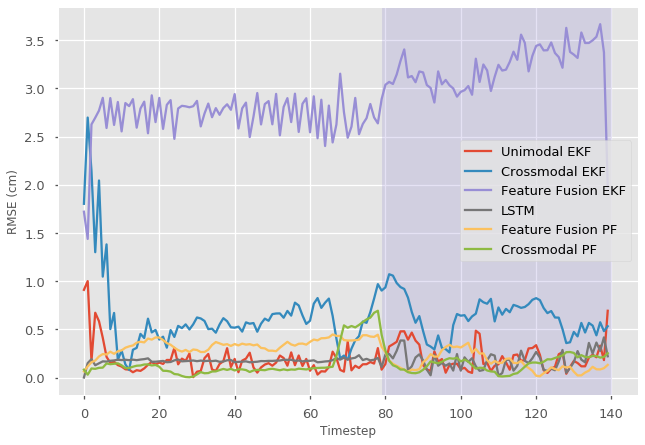

In [52]:
# plot trajectory
trajectory = 9
# trajectory = 99
file = f2


def plot_error(file, trajectory=0, label=""):
    states = file['predicted_states'][trajectory]
    actual = file['actual_states'][trajectory]

    y_error = (states[:,1] - actual[:,1]) * 0.06118315 * 100
    x_error = (states[:,0] - actual[:,0]) * 0.0572766 * 100

    total = np.sqrt(x_error**2 + y_error**2)
    
    plt.plot(total, label=label)
    print(np.mean(total))

def plot_betas(file, trajectory, fusion_type, limits):
    pred = file['predicted_states'][trajectory]
    actual = file['actual_states'][trajectory]
    force = file['force_states'][trajectory]
    image = file['image_states'][trajectory]
    beta_force = file['force_betas'][trajectory]
    beta_image = file['image_betas'][trajectory]
    contact = file['contact_states'][trajectory]
    
    print(np.argmax(contact))
    
    contact = np.argmax(contact)
    
    assert fusion_type in ["poe", "sigma"]
    if fusion_type == "poe":
        beta_force_r = 1/beta_force
        beta_image_r = 1/beta_image

        beta_force = (1/beta_force)/(beta_force_r+beta_image_r)
        beta_image = (1/beta_image)/(beta_force_r+beta_image_r)
    else:
        beta_force_r = beta_force/(beta_image+beta_force)
        beta_image_r = beta_image/(beta_image+beta_force)
        beta_force = beta_force_r
        beta_image = beta_image_r
        
#         print(beta_force)
#         print(beta_image)
    
    error = plot_fusion_traj2(pred, actual, force, image, 
                              beta_force, beta_image, 
                              contact= contact, start=5, limits=limits)

timesteps = 140
contact = 79
def color(i):
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    return colors[i % len(colors)]
plt.gca().axvspan(contact, timesteps, alpha=0.25, color=color(2))
# plt.gca().axvline(contact, color=color(2))
# plt.gca().axvline(timesteps, color=color(2))
    
plot_error(f1, trajectory, label="Unimodal EKF")
plot_error(f2, trajectory, label="Crossmodal EKF")
plot_error(f3, trajectory, label="Feature Fusion EKF")
plot_error(eval_lstm("lstm_mujoco_blackout0"), trajectory, label="LSTM")
plot_error(eval_dpf("dpf_mujoco_blackout0_unfrozen"), trajectory, label="Feature Fusion PF")
plot_error(eval_dpf_fusion("dpf_fusion_mujoco_blackout0_2x_tuned"), trajectory, label="Crossmodal PF")
plt.legend()
plt.ylabel("RMSE (cm)")
plt.xlabel("Timestep")
plt.savefig("all_errors.pdf")
plt.show()

# plot_betas(f1, trajectory, "poe", limits=[(-2.5, -0.5), (-0, 2)])
# plot_betas(f2, trajectory, "sigma", limits=[(-2.5, -0.5), (0, 2)])

In [28]:
np.sqrt(np.mean((f2['predicted_states'][:] - f2['actual_states'][:])**2))

0.0685197572434226

In [29]:
np.sqrt(np.mean((f['predicted_states'][:] - f['actual_states'][:])**2))

NameError: name 'f' is not defined

In [33]:
f = f1


In [34]:
f.keys()

<KeysViewHDF5 ['actual_states', 'contact_states', 'force_betas', 'force_states', 'image_betas', 'image_states', 'predicted_sigmas', 'predicted_states']>

In [35]:
i=4
pred = f['predicted_states'][i] * np.array((5.72, 6.11))
actual = f['actual_states'][i] * np.array((5.72, 6.11))
sigma = f['predicted_sigmas'][i]* np.array((5.72, 6.11))
beta_force = np.clip(f['force_betas'][i],0, 1) 
beta_image = np.clip(f['image_betas'][i], 0, 1)
force = f['force_states'][i]* np.array((5.72, 6.11))
image = f['image_states'][i]* np.array((5.72, 6.11))

In [36]:
beta_force_r = 1/beta_force
beta_image_r = 1/beta_image

beta_force = (1/beta_force)/(beta_force_r+beta_image_r)
beta_image = (1/beta_image)/(beta_force_r+beta_image_r)

/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.
/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """
/juno/u/brentyi/miniconda/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


140


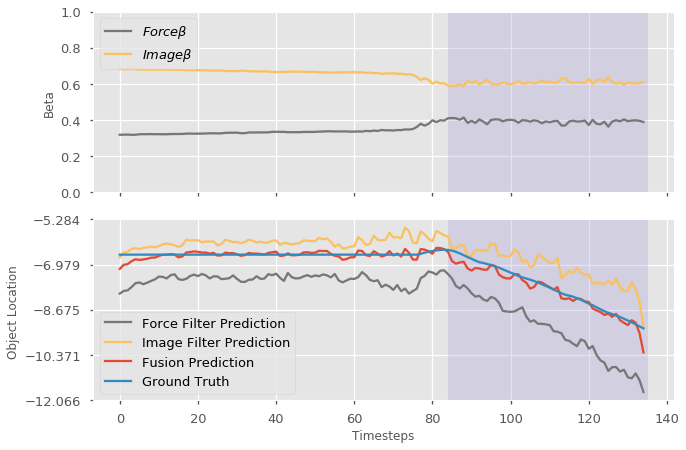

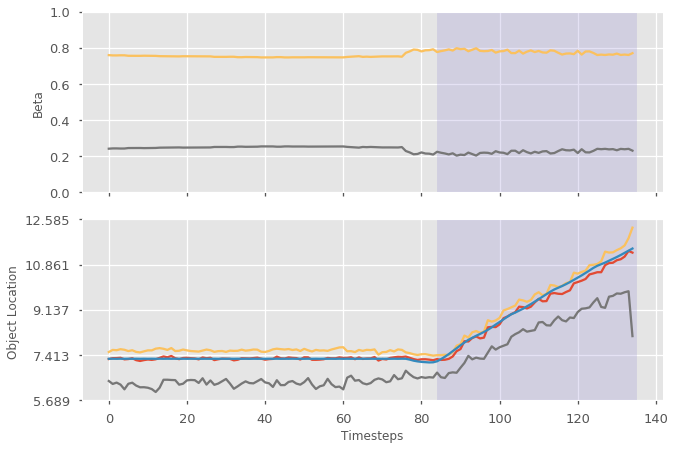

[0.17553863809224007, 0.10216832818957174]


In [37]:
error = plot_fusion_traj2(pred, actual, force, image, beta_force, beta_image, start=5)
print(error)

In [38]:
def plot_fusion_traj(pred, actual, s1, s2, b1, b2, contact=160, start=0):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    error = []
    for j in range(state_dim):
        fig = plt.figure(figsize=(8, 6))
        axes1 = fig.add_subplot(111)

        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Predicted"
        actual_label_arg['label'] = "Ground Truth"
        
        axes1.plot(range(timesteps-start),
                s1[start:, j],
                label="force",
                   c=color(3)
                )
        axes1.plot(range(timesteps-start),
                s2[start:, j], label="image", c=color(4))
                
        axes1.plot(range(timesteps-start),
                 pred[start:, j],
                     c=color(0),
                 **predicted_label_arg)
        axes1.plot(range(timesteps-start),
                 actual[start:, j],
                     c=color(1),
                 **actual_label_arg)


        axes2 = axes1.twinx()
        axes2.plot(range(timesteps-start),
                b1[start:, j], label="force beta", alpha=0.5, c=color(3)
                )
        axes2.plot(range(timesteps-start),
                b2[start:, j], label="image beta", alpha=0.5, c=color(4))  
#             conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
#             conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
#             plt.fill_between(range(timesteps-start), 
#                              conf_min, conf_max, 
#                              alpha=0.5)
        axes2.axvspan(contact, timesteps, alpha=0.25, color=color(2))
        axes2.axvline(contact, color=color(2))
        axes2.axvline(timesteps, color=color(2))
        
        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))
        error.append(rmse)

#         plt.title(f"State #{j} ")
        axes1.set_xlabel("Timesteps")
        axes1.set_ylabel("Object Location ")
        axes2.set_ylabel("Beta")
        axes2.set_ylim(0, 1.0)
        axes1.set_ylim(-10,10)
        axes2.set_xlim(0, timesteps+20)
        
        axes1.yaxis.set_major_locator(mtick.LinearLocator(5))
        axes2.yaxis.set_major_locator(mtick.LinearLocator(5))
        plt.grid(b=False)
        axes2.legend(ncol=2, bbox_to_anchor=(1.0, -0.20))
        axes1.legend(ncol=2, bbox_to_anchor=(0.5, -0.20))

#         axes1.legend()
        plt.show()

    return error

140


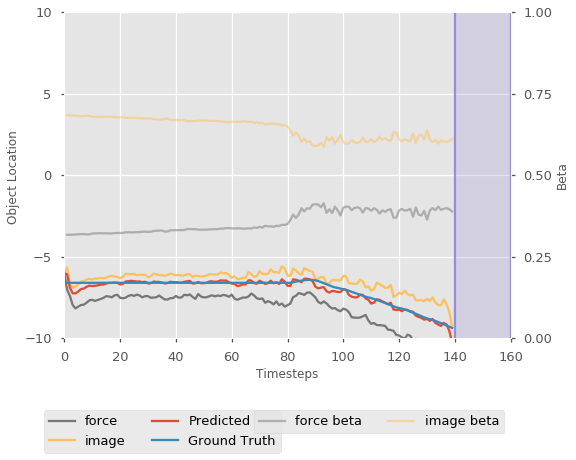

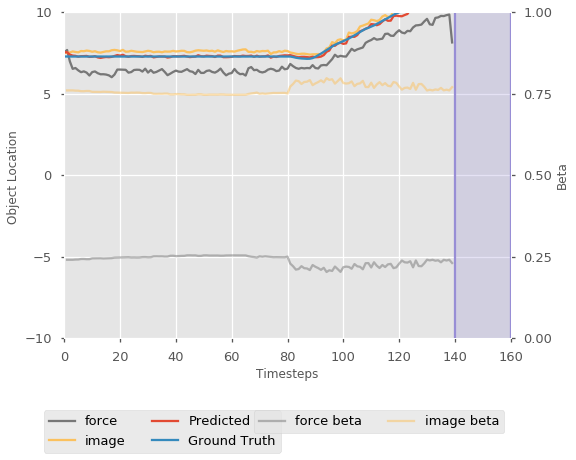

[0.20182733348061993, 0.10564547738496186]


In [39]:
error = plot_fusion_traj(pred, actual, force, image, beta_force, beta_image)
print(error)

In [40]:
def plot_fusion_traj2(pred, actual, s1, s2, b1, b2, contact=89, start=0, limits=None):
    timesteps = len(actual)
    print(timesteps)

    def color(i):
        colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        return colors[i % len(colors)]

    state_dim = actual.shape[-1]
    error = []
    for j in range(state_dim):
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0.15})
#         fig = plt.figure(figsize=(8, 6), subplots=True)
        axes1 = axs[1]
#         axes1 = fig.add_subplot(212)

        predicted_label_arg = {}
        actual_label_arg = {}

        predicted_label_arg['label'] = "Fusion Prediction"
        actual_label_arg['label'] = "Ground Truth"
        
        axes1.plot(range(timesteps-start),
                s1[start:, j],
                label="Force Filter Prediction",
                   c=color(3)
                )
        axes1.plot(range(timesteps-start),
                s2[start:, j], label="Image Filter Prediction", c=color(4))
                
        axes1.plot(range(timesteps-start),
                 pred[start:, j],
                     c=color(0),
                 **predicted_label_arg)
        axes1.plot(range(timesteps-start),
                 actual[start:, j],
                     c=color(1),
                 **actual_label_arg)

        axes2 = axs[0]
#         axes2 = fig.add_subplot(211)
        axes2.plot(range(timesteps-start),
                b1[start:, j], label=r'$Force \beta$', c=color(3)
                )
        axes2.plot(range(timesteps-start),
                b2[start:, j], label=r'$Image \beta$', c=color(4))
#             conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
#             conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
#             plt.fill_between(range(timesteps-start), 
#                              conf_min, conf_max, 
#                              alpha=0.5)
        axes2.axvspan(contact-start, timesteps-start, alpha=0.25, color=color(2))
        axes1.axvspan(contact-start, timesteps-start, alpha=0.25, color=color(2))

#         axes2.axvline(contact, color=color(2))
#         axes2.axvline(timesteps, color=color(2))
        
        rmse = np.sqrt(np.mean(
        (pred[start:, j] - actual[start:, j]) ** 2))
        error.append(rmse)

#         plt.title(f"State #{j} ")
        axes1.set_xlabel("Timesteps")
        axes1.set_ylabel("Object Location ")
        axes2.set_ylabel("Beta")
        axes2.set_ylim(0, 1)
        
        if limits is not None:
            axes1.set_ylim(limits[j][0], limits[j][1])
        
#         axes1.set_ylim(-2,4)
#         axes2.xaxis.label.set_visible(False)
#         axes2.set_xticklabels([])
        axes2.use_sticky_edges = False
        axes2.margins(0.05, 0.05) # 5% padding in all directions
        axes1.yaxis.set_major_locator(mtick.LinearLocator(5))
#         axes2.yaxis.set_major_locator(mtick.LinearLocator(5))
#         axes2.tick_params(axis="y", direction="in")
#         plt.grid(b=False)
#         axes2.legend(ncol=2, bbox_to_anchor=(1.0, -1.80))
#         axes1.legend(ncol=2, bbox_to_anchor=(0.5, -0.20))
        
        if j==0:
            axes1.legend()
            axes2.legend()
        plt.show()

    return error

140


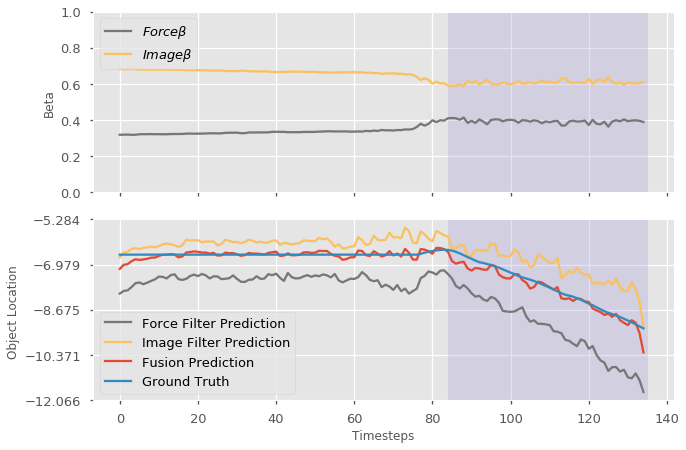

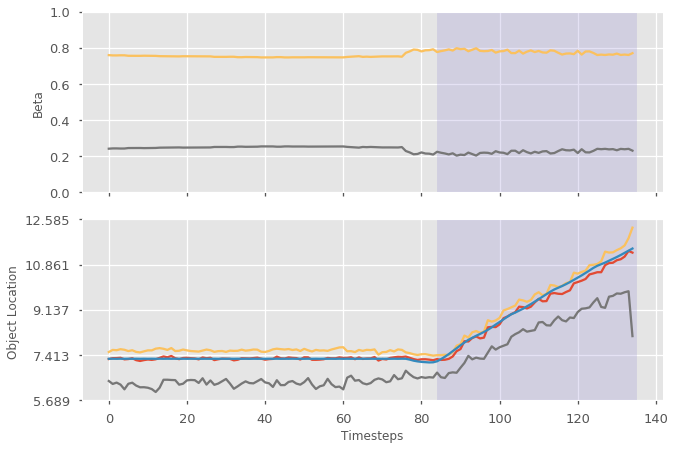

[0.17553863809224007, 0.10216832818957174]


In [41]:
error = plot_fusion_traj2(pred, actual, force, image, beta_force, beta_image, start=5)
print(error)

In [42]:
def plot_kf_traj(pred, actual, sigma, plot=False, plot_traj=None, start=0):

    if plot:
        timesteps = len(actual)
        print(timesteps)

        def color(i):
            colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
            return colors[i % len(colors)]

        state_dim = actual.shape[-1]
        for j in range(state_dim):
            plt.figure(figsize=(8, 6))
          

            predicted_label_arg = {}
            actual_label_arg = {}

            predicted_label_arg['label'] = "Predicted"
            actual_label_arg['label'] = "Ground Truth"
            plt.plot(range(timesteps-start),
                     pred[start:, j],
#                      c=color(0),
                     **predicted_label_arg)
            plt.plot(range(timesteps-start),
                     actual[start:, j],
#                      c=color(1),
                     **actual_label_arg)
            
            conf_min = pred[start:, j] - sigma[start:, j, j] *0.5
            conf_max = pred[start:, j] + sigma[start:, j, j] *0.5
            plt.fill_between(range(timesteps-start), 
                             conf_min, conf_max, 
                             alpha=0.5)
            
            rmse = np.sqrt(np.mean(
            (pred[start:, j] - actual[start:, j]) ** 2))

            plt.title(f"State #{j} ")
            plt.xlabel("Timesteps")
            plt.ylabel("Value")
#             plt.legend()
#             plt.ylim(-2, 2)
            plt.show()


140


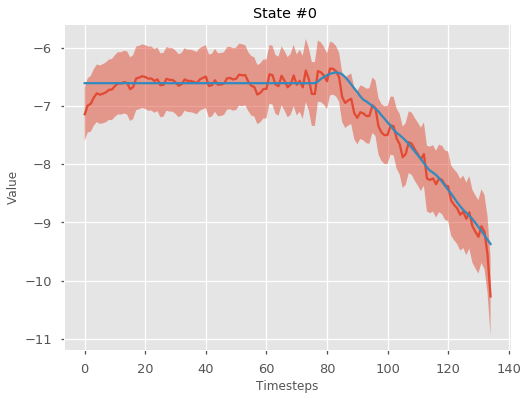

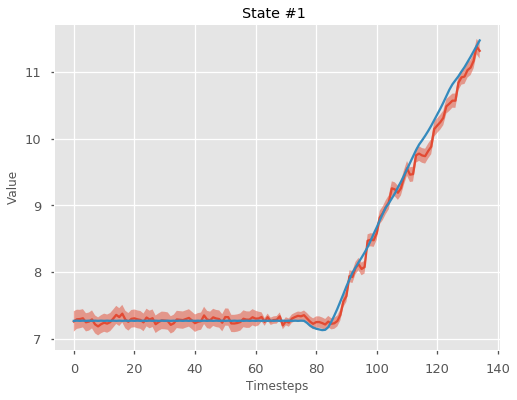

In [43]:
plot_kf_traj(pred, actual, sigma, plot=True, start=5)